In [64]:
import pandas as pd
import numpy as np
import datetime as dt
import itertools
import warnings
import chainladder as cl # Sparse=0.14.0 ; incremental.py np.NINF -> -np.inf
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [65]:
def claims_formatter(doc:pd.DataFrame):
    doc_copy = doc.copy()
    #Acomodo indice
    doc_copy.index = doc_copy.AUTOMOTORES
    formatted_doc = doc_copy.iloc[:,4:].stack(level = [0,1,2,3]).reset_index([1,2,3,4]).drop_duplicates()
    formatted_doc.reset_index(inplace = True)
    formatted_doc[['Base Origen', 'Ramo', 'Codigo 1', 'Codigo 2']] = pd.DataFrame(formatted_doc[('index','')].to_list(), index = formatted_doc.index)

    #Acomodo columnas
    formatted_doc.columns = ['indice','Tipo', 'Periodo', 'Desarrollo 1', 'Año Valuacion', 'Pendientes', 'Pagados', 'Incurridos', 'Cantidad', 'Base Origen', 'Ramo', 'Codigo 1', 'Codigo 2']
    formatted_doc['Año Ocurrencia'] = pd.to_datetime(formatted_doc['Periodo'][0][0:5]) + pd.DateOffset(months = 6)
    formatted_doc['Año Valuacion'] = pd.to_datetime(formatted_doc['Año Valuacion'])
    #formatted_doc['Desarrollo'] = formatted_doc['Año Valuacion'] - formatted_doc['Año Ocurrencia']
    formatted_doc.drop(['indice','Tipo', 'Periodo', 'Desarrollo 1'], axis = 1, inplace = True)

    return formatted_doc

def check_chainladdes_assumptions(triangle:cl.Triangle, columns:list):
    for column in columns:
        if triangle[column].sum().valuation_correlation(p_critical=0.1, total=True).z_critical.values == True:
            print(f'Triangulo {column}: Años de valuación correlacionados')
        elif triangle[column].sum().development_correlation(p_critical=0.1).t_critical.values == False:
            print(f'Triangulo {column}: Años de desarrollo no correlacionados')
            

In [66]:
sto_input = pd.read_excel(r'D:\Documentos\Python_script\Github\IBNR-NIIF-17\sample\ssn_20232024_desarrollo_siniestros_automotores.xlsx', sheet_name = None, header=[0,1,2,3,4,5])
facpce_input = pd.read_excel(r'D:\Documentos\Python_script\Github\IBNR-NIIF-17\sample\Indice-FACPCE-Res.-JG-539-18-_2025-07-1.xlsx', skiprows = 2, skipfooter=4)

#Tratamiendo desarrollo de stos
#sto_input = dict(itertools.islice(sto_input.items(), 3, len(sto_input)))
sto_input_formateado = [claims_formatter(sto_input[k]) for k in sto_input.keys() if k[0] == '2']
db_stos = pd.concat(sto_input_formateado)

#Tratamiento indice facpce
db_facpce = facpce_input.set_index('MES')
factores_facpce = db_facpce.loc[max(db_stos['Año Valuacion']) - pd.DateOffset(days = 29)] / db_facpce.loc[db_stos['Año Valuacion'] - pd.DateOffset(months = 5, days = 29)] # Asumo que esta todo valuado a mitad de periodo.
db_stos['Factor FACPSE'] = factores_facpce.set_index(db_stos.index)

In [67]:
#Armo el dataframe para el triángulo que quiero analizar 
idx = (db_stos['Base Origen'] == '[HG]') &  (db_stos['Ramo'] == 'RC')
db_triangle = db_stos.loc[idx, ['Año Ocurrencia', 'Año Valuacion', 'Pendientes','Pagados' , 'Incurridos', 'Factor FACPSE']]
db_triangle['Año Valuacion'] = db_triangle['Año Valuacion'] + pd.DateOffset(months = -6)
db_triangle['Año Ocurrencia'] = db_triangle['Año Ocurrencia'] + pd.DateOffset(months = -6)

#Chequeo supuestos para Cl y aplico el factor FACPCE
triang_stos = cl.Triangle(db_triangle, origin = 'Año Ocurrencia', development= 'Año Valuacion', columns = ['Pagados', 'Pendientes', 'Incurridos'], cumulative = True)
triang_facpce = cl.Triangle(db_triangle, origin = 'Año Ocurrencia', development= 'Año Valuacion', columns = 'Factor FACPSE', cumulative = True)
triang_stos_act = triang_stos.cum_to_incr() * triang_facpce
check_chainladdes_assumptions(triang_stos_act, ['Pagados', 'Pendientes', 'Incurridos'])

In [68]:
raa = triang_stos_act
model = cl.Development().fit(triang_stos_act)
#model.std_residuals_

In [69]:
triang_stos_act['Pagados'].incr_to_cum()

,12,24,36,48,60,72
2018,"710,583,688,912","1,079,948,016,120","1,210,634,929,405","1,305,796,021,755","1,354,715,076,975","1,389,218,747,991"
2019,"568,881,611,478","824,256,617,759","922,314,621,414","968,737,242,486","1,002,195,517,255",
2020,"532,099,551,028","846,642,591,841","901,118,679,597","937,486,188,701",,
2021,"626,513,979,226","848,893,918,586","907,970,627,951",,,
2022,"422,521,028,677","569,011,405,399",,,,
2023,"378,112,192,419",,,,,


In [70]:
triang_stos_act['Incurridos'].incr_to_cum().link_ratio.heatmap()

,12-24,24-36,36-48,48-60,60-72
2018,1.3682,1.1139,1.0986,1.0477,1.0351
2019,1.3358,1.1494,1.0520,1.0452,
2020,1.3681,1.0968,1.0510,,
2021,1.2873,1.0991,,,
2022,1.2862,,,,


In [71]:
triang_stos_act['Pagados'].incr_to_cum().link_ratio.heatmap()

,12-24,24-36,36-48,48-60,60-72
2018,1.5198,1.1210,1.0786,1.0375,1.0255
2019,1.4489,1.1190,1.0503,1.0345,
2020,1.5911,1.0643,1.0404,,
2021,1.3549,1.0696,,,
2022,1.3467,,,,


In [72]:
triang_stos_act['Pendientes'].incr_to_cum().link_ratio.heatmap()

,12-24,24-36,36-48,48-60,60-72
2018,1.1127,1.0974,1.1457,1.0704,1.0558
2019,1.1284,1.2211,1.0556,1.0682,
2020,1.0408,1.1696,1.0726,,
2021,1.1911,1.1467,,,
2022,1.2278,,,,


TypeError: no numeric data to plot

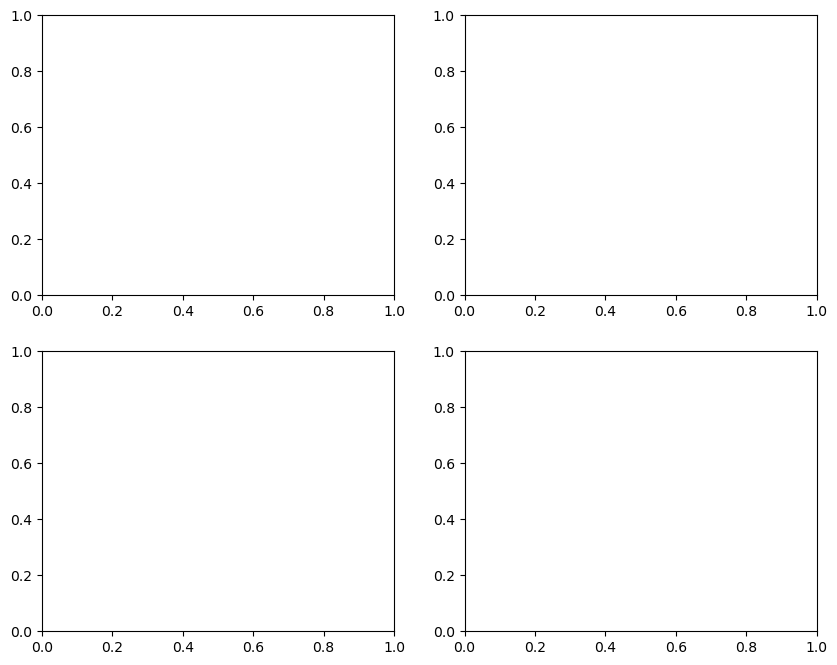

In [73]:
fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(ncols=2, nrows=2, figsize=(10,8))
model.std_residuals_.T.plot(
    style='.', color='gray', legend=False, grid=True, ax=ax00,
    xlabel='Development Month', ylabel='Weighted Standardized Residuals')
model.std_residuals_.iloc[..., :-1].mean('origin').T.plot(
    color='red', legend=False, grid=True, ax=ax00)
model.std_residuals_.plot(
    style='.', color='gray', legend=False, grid=True, ax=ax01, xlabel='Origin Period')
model.std_residuals_.mean('development').plot(
    color='red', legend=False, grid=True, ax=ax01)
model.std_residuals_.dev_to_val().T.plot(
    style='.', color='gray', legend=False, grid=True, ax=ax10,
    xlabel='Valuation Date', ylabel='Weighted Standardized Residuals')

model.std_residuals_.dev_to_val().mean('origin').T.plot(color='red', legend=False, grid=True, ax=ax10)
pd.concat((
    (raa[raa.valuation<raa.valuation_date]*model.ldf_.values).unstack().rename('Fitted Values'),
    model.std_residuals_.unstack().rename('Residual')), axis=1).dropna().plot(
    kind='scatter', marker='o', color='gray', x='Fitted Values', y='Residual', ax=ax11, grid=True, sharey=True)
fig.suptitle("Barnett Zehnwirth\nStandardized residuals of the Extended Link Ratio Family (ELRF)\n(Fig 2.6)")

In [ ]:
dev = cl.Development(average = 'simple').fit(triang_stos_act)
dev.cdf_

,12-Ult,24-Ult,36-Ult,48-Ult,60-Ult
(All),1.7823,1.2273,1.1223,1.0624,1.0255
